In [244]:
import pandas as pd
from datetime import datetime

In [245]:
weather_data_filepath = "data/weather_data.csv"
electricity_data_filepath = "data/electricity_production_data.csv"

In [246]:
df_weather = pd.read_csv(weather_data_filepath, delimiter=',')
df_electricity = pd.read_csv(electricity_data_filepath, delimiter=',')

df_weather['time'] = pd.to_datetime(df_weather['referenceTime'])
df_electricity['time'] = pd.to_datetime(df_electricity['måned'], format='%YM%m')
df_weather = df_weather.drop(columns="referenceTime")
df_electricity = df_electricity.drop(columns="måned")

df_weather['month_year'] = df_weather['time'].dt.strftime('%Y-%m')
df_electricity['month_year'] = df_electricity['time'].dt.strftime('%Y-%m')

df_weather['rolling_mean_precipitation'] = df_weather['value'].rolling(window=6).mean()
df_electricity['rolling_mean_electricity'] = df_electricity['value'].rolling(window=6).mean()

df_filtered_weather = df_weather[(df_weather['month_year'] >= df_electricity['month_year'].min()) & (df_weather['month_year'] <= df_electricity['month_year'].max())]
df_filtered_weather.reset_index(drop=True, inplace=True)

In [247]:
df_weather.describe()

,value,rolling_mean_precipitation
count,822.000000,817.000000
mean,71.013382,71.103631
std,40.911546,19.355718
min,0.500000,27.700000
25%,40.425000,58.466667
50%,65.200000,69.466667
75%,92.475000,81.933333
max,270.400000,155.416667


In [248]:
df_electricity.describe()

,value,time,rolling_mean_electricity
count,2.280000e+02,228,223.000000
mean,6.273899e+05,2002-06-16 13:41:03.157894784,625803.285501
min,2.629900e+05,1993-01-01 00:00:00,335237.166667
25%,4.935690e+05,1997-09-23 12:00:00,535929.833333
50%,6.249945e+05,2002-06-16 00:00:00,638546.166667
75%,7.545198e+05,2007-03-08 18:00:00,705661.500000
max,1.031794e+06,2011-12-01 00:00:00,874816.166667
std,1.670362e+05,NaN,115648.362069


In [249]:
df_filtered_weather.head()

,value,time,month_year,rolling_mean_precipitation
0,96.6,1993-01-31 23:00:00+00:00,1993-01,62.366667
1,57.0,1993-02-28 23:00:00+00:00,1993-02,68.200000
2,21.2,1993-03-31 22:00:00+00:00,1993-03,59.800000
3,62.1,1993-04-30 22:00:00+00:00,1993-04,60.666667
4,61.5,1993-05-31 22:00:00+00:00,1993-05,60.216667


In [250]:
df_electricity.head()

,value,time,month_year,rolling_mean_electricity
0,698737,1993-01-01,1993-01,NaN
1,654965,1993-02-01,1993-02,NaN
2,673560,1993-03-01,1993-03,NaN
3,488486,1993-04-01,1993-04,NaN
4,465860,1993-05-01,1993-05,NaN


In [251]:
import matplotlib.pyplot as plt

def plot_values(data: pd.DataFrame, x_var="time", y_var="value", title: str = None, xlabel="Time", ylabel = "Value"):
    plt.figure(figsize=(12,6))
    plt.plot(data[x_var], data[y_var], marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [252]:
merged_df = pd.merge(df_filtered_weather, df_electricity, on='month_year', suffixes=('_precipitation', '_electricity'))

In [253]:
merged_df.head()

,value_precipitation,time_precipitation,month_year,rolling_mean_precipitation,value_electricity,time_electricity,rolling_mean_electricity
0,96.6,1993-01-31 23:00:00+00:00,1993-01,62.366667,698737,1993-01-01,NaN
1,57.0,1993-02-28 23:00:00+00:00,1993-02,68.200000,654965,1993-02-01,NaN
2,21.2,1993-03-31 22:00:00+00:00,1993-03,59.800000,673560,1993-03-01,NaN
3,62.1,1993-04-30 22:00:00+00:00,1993-04,60.666667,488486,1993-04-01,NaN
4,61.5,1993-05-31 22:00:00+00:00,1993-05,60.216667,465860,1993-05-01,NaN


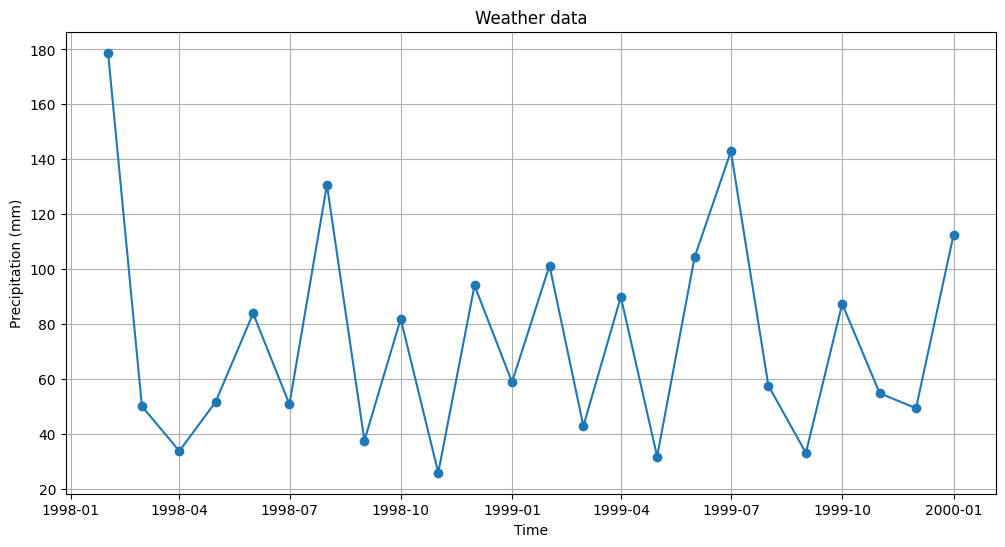

In [254]:
plot_values(df_weather[(df_weather['time'].dt.year >= 1998) & (df_weather['time'].dt.year <= 1999)], title="Weather data", ylabel="Precipitation (mm)")

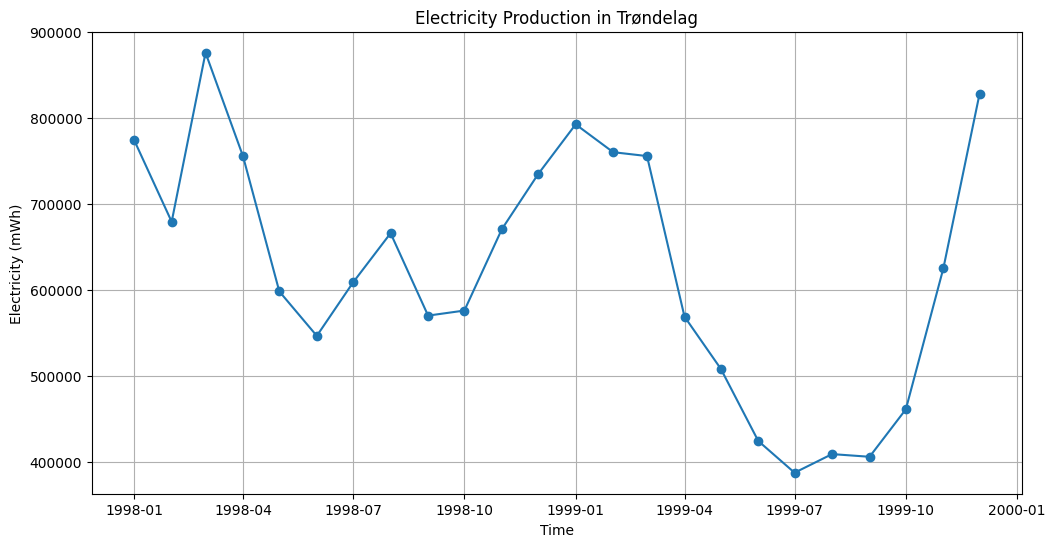

In [255]:

plot_values(df_electricity[(df_electricity['time'].dt.year >= 1998) & (df_electricity['time'].dt.year <= 1999)], title="Electricity Production in Trøndelag", ylabel="Electricity (mWh)")

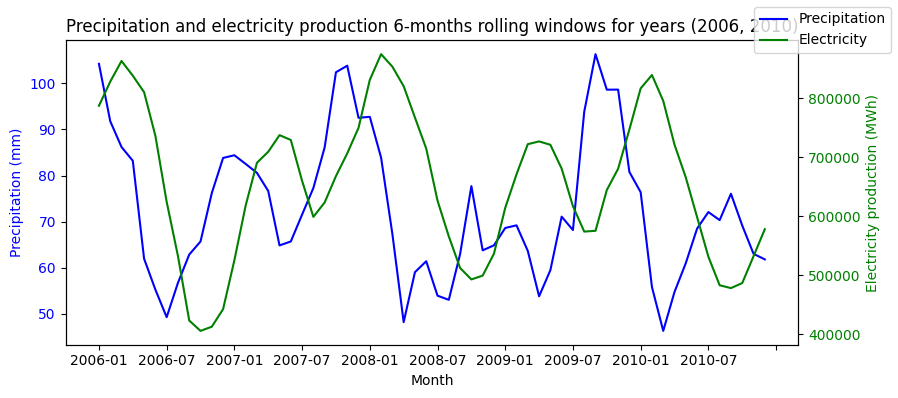

In [257]:
from matplotlib.ticker import MaxNLocator

def plot_for_years(df: pd.DataFrame, start_year: int, end_year: int):
    df_merged_filtered = df[(df['time_electricity'].dt.year >= start_year) & (df['time_electricity'].dt.year <= end_year)]

    fig, ax1 = plt.subplots(figsize=(9,4))

    ax1.plot(df_merged_filtered['month_year'], df_merged_filtered['rolling_mean_precipitation'], color='blue', label='Precipitation')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Precipitation (mm)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=12))  # Set the number of x-axis ticks


    ax2 = ax1.twinx()
    ax2.plot(df_merged_filtered['month_year'], df_merged_filtered['rolling_mean_electricity'], color='green', label='Electricity')
    ax2.set_ylabel('Electricity production (MWh)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    if end_year-start_year == 0:
        plt.title(f'Precipitation and electricity production for year {start_year}')
    else:
        plt.title(f'Precipitation and electricity production 6-months rolling windows for years {start_year, end_year}')
    fig.tight_layout()
    fig.legend()
    plt.show()

plot_for_years(merged_df, 2006, 2010)

Very seasonal, precipitation leading for electricity?

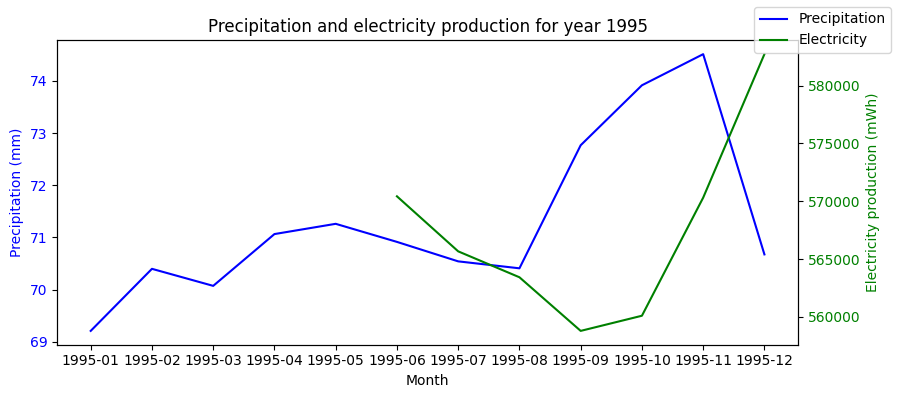

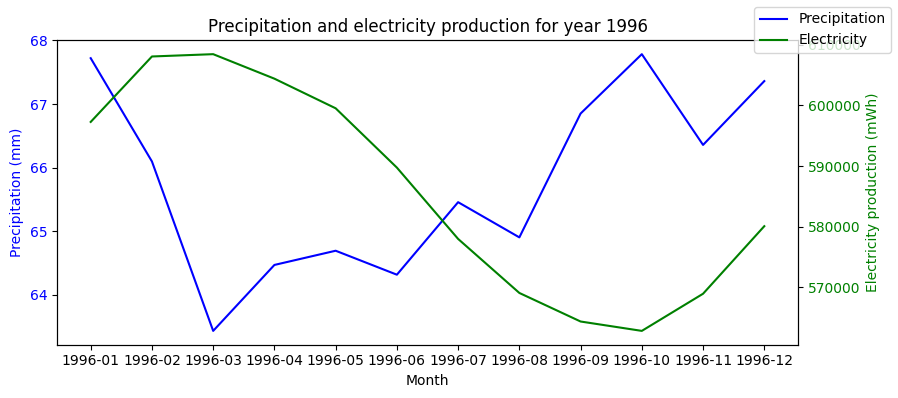

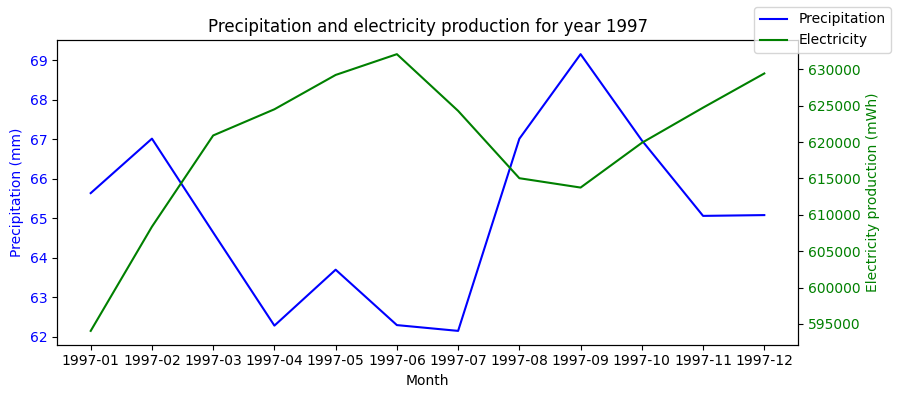

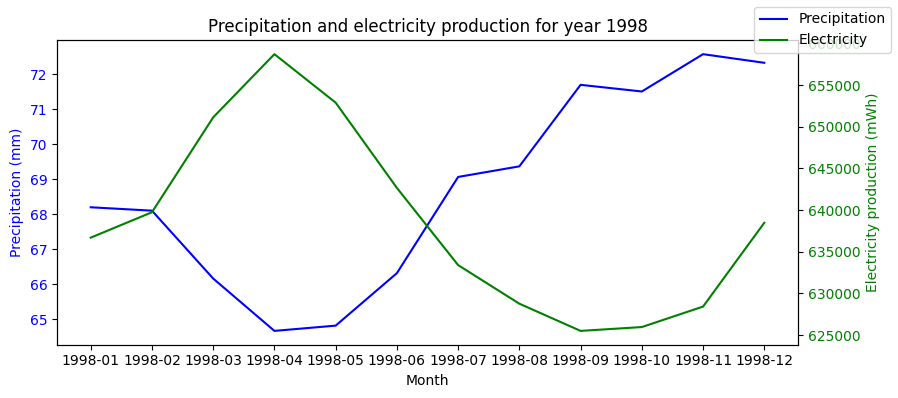

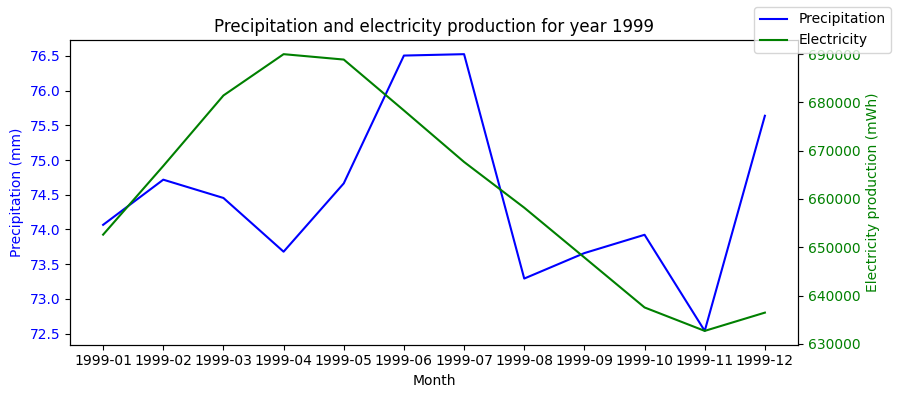

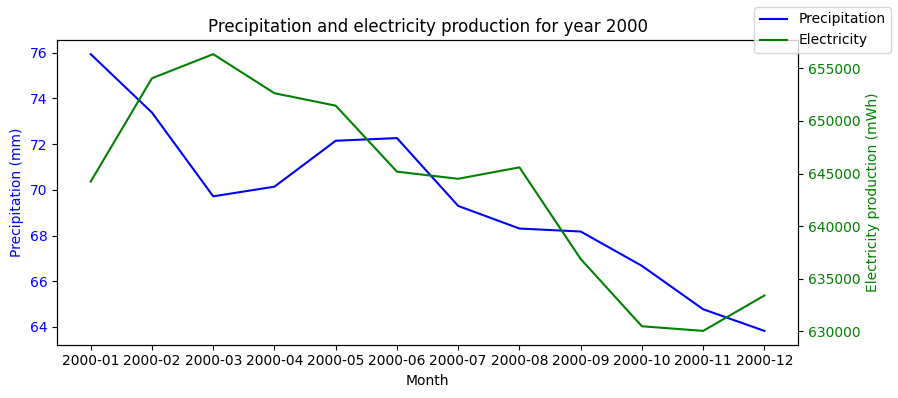

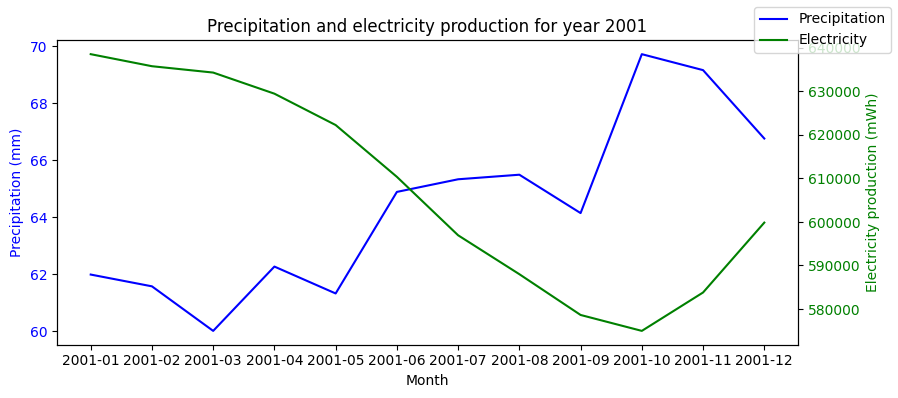

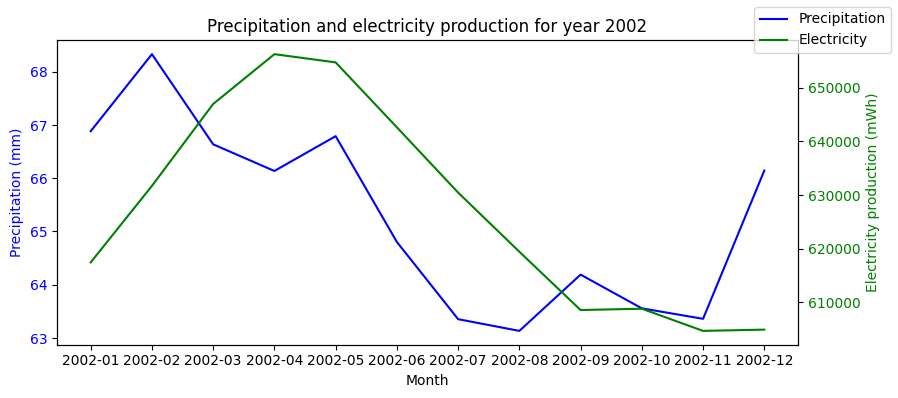

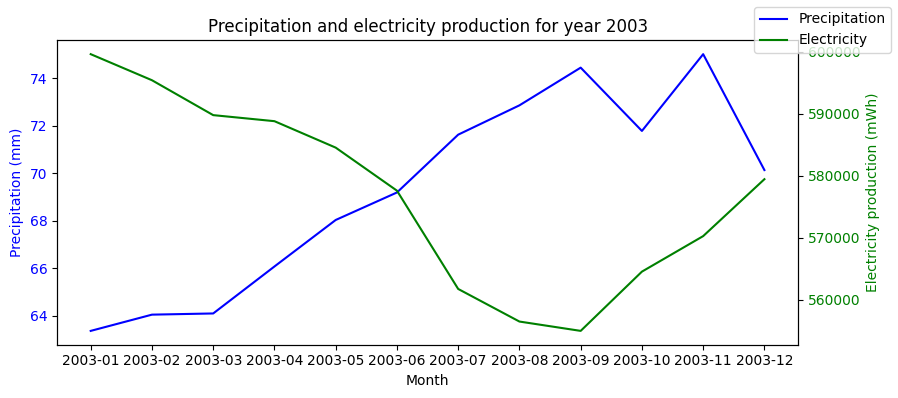

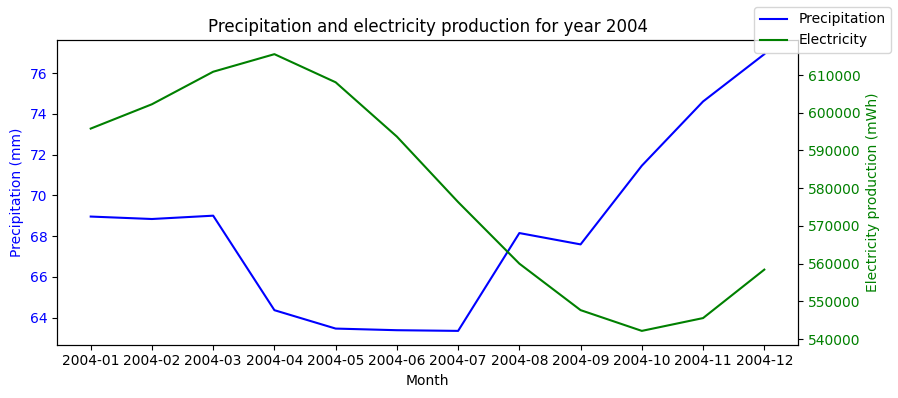

In [203]:
for i in range(1995, 2005):
    plot_for_years(merged_df, i, i)

In [204]:
correlation = df_weather['value'].corr(df_electricity['value'])

print(correlation)

-0.06170420388379766


In [205]:
df_weather['rolling_mean_precipitation'] = df_weather['value'].rolling(window=30).mean()
df_electricity['rolling_mean_electricity'] = df_electricity['value'].rolling(window=30).mean()

In [206]:
df_electricity.describe()

,value,time,rolling_mean_electricity
count,2.280000e+02,228,199.000000
mean,6.273899e+05,2002-06-16 13:41:03.157894784,630689.866164
min,2.629900e+05,1993-01-01 00:00:00,542170.000000
25%,4.935690e+05,1997-09-23 12:00:00,608055.550000
50%,6.249945e+05,2002-06-16 00:00:00,632683.600000
75%,7.545198e+05,2007-03-08 18:00:00,655791.983333
max,1.031794e+06,2011-12-01 00:00:00,707996.733333
std,1.670362e+05,NaN,38728.726150


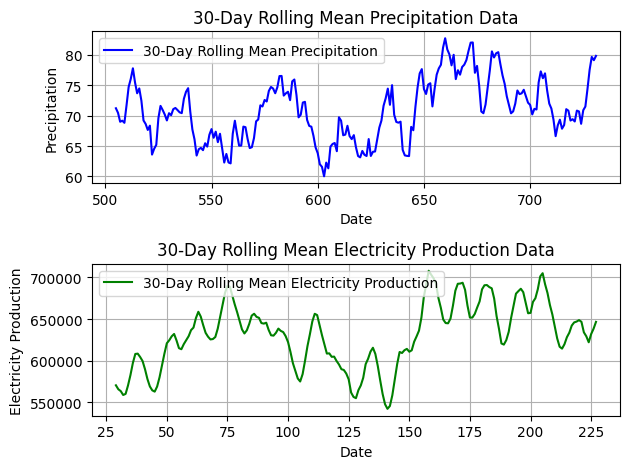

In [207]:
df_weather['time'] = df_weather['time'].dt.tz_localize(None)
df_electricity['time'] = df_electricity['time'].dt.tz_localize(None)

filtered_weather_df = df_weather[(df_weather['time'] > df_electricity['time'].min()) & (df_weather['time'] < df_electricity['time'].max())]
plt.subplot(2, 1, 1)
plt.plot(filtered_weather_df.index, filtered_weather_df['rolling_mean_precipitation'], label='30-Day Rolling Mean Precipitation', color='blue')
plt.title('30-Day Rolling Mean Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_electricity.index, df_electricity['rolling_mean_electricity'], label='30-Day Rolling Mean Electricity Production', color='green')
plt.title('30-Day Rolling Mean Electricity Production Data')
plt.xlabel('Date')
plt.ylabel('Electricity Production')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

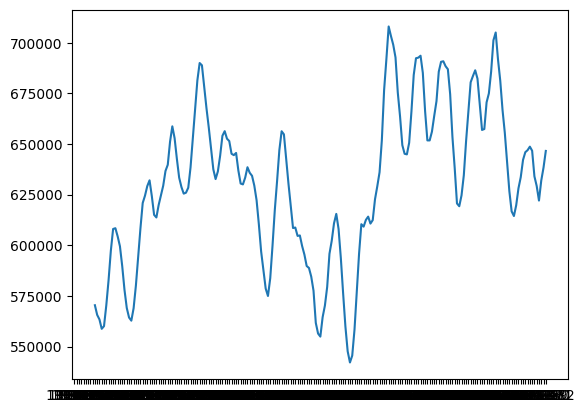

In [208]:
plt.plot(merged_df['month_year'], merged_df['rolling_mean_electricity'])

## Summary statistics

In [210]:
# Summary statistics for precipitation data
precipitation_summary = df_filtered_weather['value'].describe()
print("Precipitation Data Summary:")
print(precipitation_summary)

# Summary statistics for electricity production data
electricity_summary = df_electricity['value'].describe()
print("\nElectricity Production Data Summary:")
print(electricity_summary)

# Calculate correlation between precipitation and electricity production
correlation = merged_df['value_precipitation'].corr(merged_df['value_electricity'])

print(f"\nCorrelation between Precipitation and Electricity Production: {correlation}")

Precipitation Data Summary:
count    228.000000
mean      71.486404
std       40.599599
min        0.500000
25%       45.750000
50%       62.700000
75%       91.750000
max      220.600000
Name: value, dtype: float64

Electricity Production Data Summary:
count    2.280000e+02
mean     6.273899e+05
std      1.670362e+05
min      2.629900e+05
25%      4.935690e+05
50%      6.249945e+05
75%      7.545198e+05
max      1.031794e+06
Name: value, dtype: float64

Correlation between Precipitation and Electricity Production: -0.21740326228389276
